In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob, math
import os
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN
from IPython.core.debugger import Pdb
warnings.filterwarnings("ignore")

In [2]:
def sub_plots(dataset, title, activitites):
    
  size = len(dataset)
  ncols = math.ceil(math.sqrt(size))
  nrows = math.ceil(size / ncols)

  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
  
  for i, (data, act) in enumerate(zip(dataset, activitites)):
      row = i // 3
      col = i % 3
      data.plot(x='SPO', y='heart_rate', kind='scatter', ax=axes[row, col], title=act)
      axes[row, col].set_xlabel('SPO2')
     
  plt.tight_layout()
  fig.suptitle(title, fontsize=16)
  plt.show()

In [3]:
def get_datasets(path):
 
    _,_, files_v = next(os.walk(path[0]))
    _,_, files_a = next(os.walk(path[1]))
    
    df_v_list = []
    df_a_list = []

    # Vitals files
    for i in range(len(files_v)):        
        temp_df = pd.read_csv(os.path.join(path[0],files_v[i]),sep = ',')
        df_v_list.append(temp_df)
    # Acc files    
    for i in range(len(files_a)):
        temp_df = pd.read_csv(os.path.join(path[1],files_a[i]),sep = ',')
        df_a_list.append(temp_df)
        
    return df_v_list, df_a_list

In [4]:
def reduce_dataset_v(n,data_v2):
    data_v2 = data_v2.groupby(np.arange(len(data_v2))// (len(data_v2)/n)).mean()
    data_v2[['person_id', 'exercise']] = data_v2[['person_id', 'exercise']].astype(int) 
    return data_v2

def reduce_dataset_a(n,data_a2):
    data_a2 = data_a2.groupby(np.arange(len(data_a2))// (len(data_a2)/n)).first()
    return data_a2

def reduce_datset(n,m,data_v, data_a):
    
    data_v2 = data_v.copy()
    data_a2 = data_a.copy()
    
    # Vitals data
    for i in range(len(data_v2)):
        # Remove "-999" values
        data_v2[i].loc[data_v2[i]['SPO'] < 0, 'SPO'] = data_v2[i].loc[data_v2[i]['SPO'] > 0, 'SPO'].mean()
        
        # Reduce set size by taking window average
        data_v2[i] = reduce_dataset_v(n,data_v2[i])
    
    # Acc data
    for i in range(len(data_a2)):
        # Reduce set size by taking first value from window
        data_a2[i] = reduce_dataset_a(m,data_a2[i])
        
    return data_v2, data_a2

In [5]:
# Concat all subsets files into a single dataframe
def concat_datsets(df_v_list_new, df_a_list_new):
    data_set_v = []
    data_set_a = []
    for i in range(len(df_v_list_new)):
        data_set_v.append(df_v_list_new[i])

    for i in range(len(df_a_list_new)):
        data_set_a.append(df_a_list_new[i])

    data_set_v = pd.concat(data_set_v, axis=0).reset_index(drop=True)
    data_set_a = pd.concat(data_set_a, axis=0).reset_index(drop=True)
    
    return data_set_v, data_set_a

In [6]:
# Remove outliers using Standard Deviation Method
def remove_outliers_sd(data_o, sd):
    
    data= data_o.copy()

    spo_mean, spo_std = data.SPO.mean(), data.SPO.std()
    hr_mean, hr_std = data.heart_rate.mean(), data.heart_rate.std()

    spo_cut_off = spo_std * sd
    hr_cut_off = hr_std * sd

    spo_lower, spo_upper = spo_mean - spo_cut_off, spo_mean + spo_cut_off
    hr_lower, hr_upper = hr_mean - hr_cut_off, hr_mean + hr_cut_off

    data = data.loc[(data['SPO'] >= spo_lower) & (data['SPO'] <= spo_upper) ].reset_index(drop=True)
    data = data.loc[(data['heart_rate'] >= hr_lower) & (data['heart_rate'] <= hr_upper) ].reset_index(drop=True)
   
    return data

In [7]:
# Remove outliers using SBSCAN
def outliers_cluster_dbscan(data, eps, min_samples, remove_out, title):
    
    data_set_dbs = []
    X=data[['SPO','heart_rate']]
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k
        
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy.SPO, xy.heart_rate, "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=14, )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy.SPO, xy.heart_rate, "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=6,)
        plt.xlabel('SPO2')
        plt.ylabel('Heart rate')

    plt.title(title)
    plt.show()
    
    # Remove points labeled as noise (-1)
    if remove_out == True:
        lab= pd.DataFrame(labels, columns=['dbscan_label'])
        data_set_dbs = pd.concat([X, lab], axis=1)
        data_set_dbs = data_set_dbs[data_set_dbs.dbscan_label != -1].reset_index(drop=True)
        #plt.scatter(data_set_dbs.SPO,data_set_dbs.heart_rate)
        #plt.show()
    
    return data_set_dbs

# Read files for individual experiments

The data collected is stored in the following structure. 

```
training
        |-- 0-Baseline
                |-- vitals
                        |-- experiment_person_1.csv
                        |-- experiment_person_n.csv
                        |-- ...
                |-- acc
                        |-- experiment_person_1.csv
                        |-- experiment_person_n.csv
                        |-- ...
        |-- 0-Walking
                |-- vitals
                        |-- ...
                |-- acc
                        |-- ...
        |-- ...
test
        |-- 0-Baseline
                    |-- ...

```               
We use Pandas library to handle data files as dataframes.
  
Files for each exercise are read and stored into a list of dataframes. We distinguish between data coming from sensor (vitals) and xyz acceleration (acc).

In [8]:
train_path= os.path.join(os.getcwd(),'train')
data_type = ['vitals', 'acc']
vitals_acc_data = []

test_path= os.path.join(os.getcwd(),'test')

activities = [f.name for f in os.scandir(train_path) if f.is_dir()]

for act in activities:
    path = [os.path.join(train_path,act,f) for f in data_type]
    vitals_acc_data.append(get_datasets(path))


From the recording phase and manual inspection of the data, we notice the sensor constantly gives flawed values such as “-999”. These points were replaced by the mean of the rest SPO/ HR values.
  
Since the amount of data collected for each experiment differs, we took the same amount of data for each experiment, and single dataframe per exercise is generated.

In [9]:
# Rows to take for each vital file
min=1000
# Rows to take for each acc file
n= 3500

red_data = []
concat_data = []

for act in vitals_acc_data:
    red_data.append(reduce_datset(min,n,act[0],act[1]))

for red in red_data:
    concat_data.append(concat_datsets(red[0], red[1]))

The following plot show the original distribution of SPO and Heart rate for each exercise type.

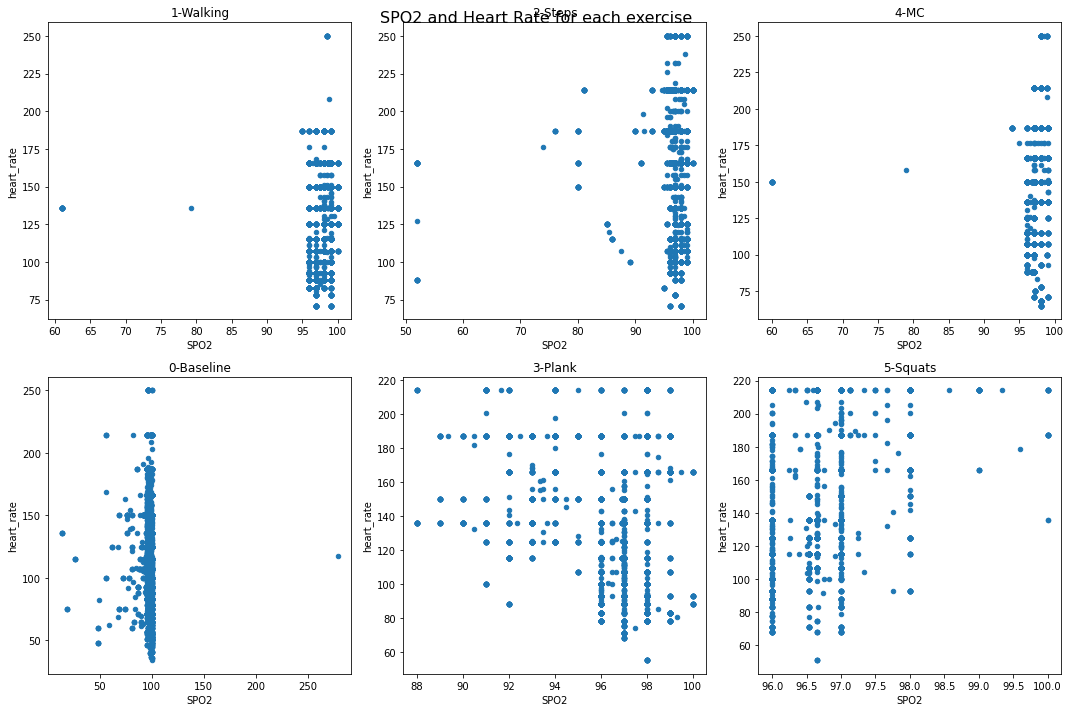

In [10]:
vitals_data = [x[0] for x in concat_data]
acc_data = [x[1] for x in concat_data]

sub_plots(vitals_data, 'SPO2 and Heart Rate for each exercise', activities)

## Outlier removal:

From the preovious plot we can note isolated points. Considering some unsual sensor behaviour during our data recording phase, and due to none of the participants have heart or respiratory diseases, we decide to treat those points as outliers instead of exceptional cases.
  
We plot the density distribution of Heart rate and SPO for each exercise. Even though the data is noisy and presents some peaks, it is more less symmetric, therefore we assume it is normal distributed and we address outlier removal using the Standard Deviation Method.

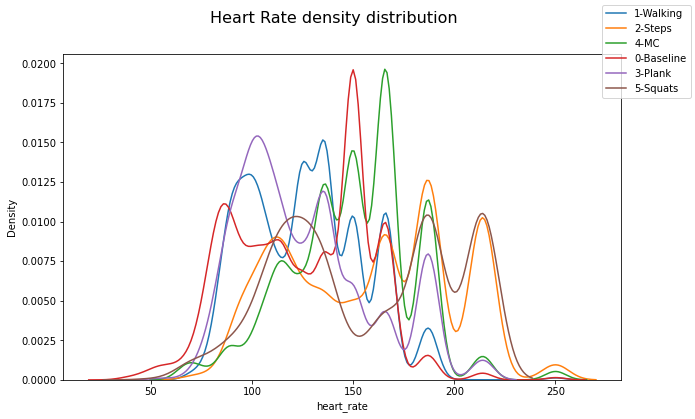

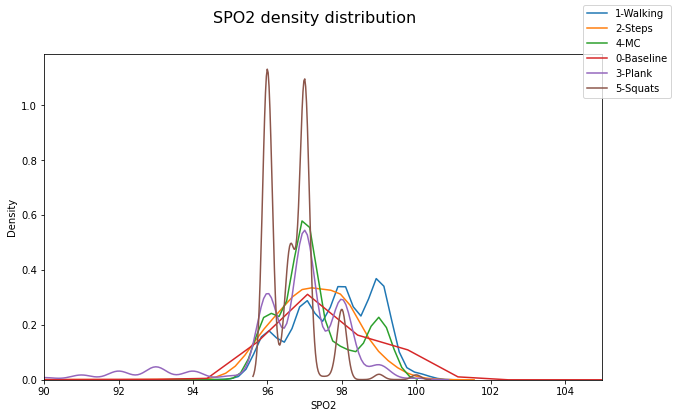

In [11]:
fig = plt.figure(figsize=(10,6))
for data in vitals_data:
    sns.distplot(data['heart_rate'], hist=False)
fig.legend(labels=activities)
fig.suptitle('Heart Rate density distribution', fontsize=16)
plt.show()

fig = plt.figure(figsize=(10,6))
for data in vitals_data:
    sns.distplot(data['SPO'], hist=False)
fig.legend(labels=activities)
plt.xlim(90, 105)
plt.xlabel('SPO2')
fig.suptitle('SPO2 density distribution', fontsize=16)
plt.show()

### Standard Deviation Method
For this approach, we compute lower and upper limits from data mean of each exercise and remove the points that fall outside 2 standard deviations, which are not considered part of the distribution.

In [12]:
# Remove outliers with Standard Deviation Method
sd = 2
vitals_data_std = [remove_outliers_sd(data,sd) for data in vitals_data]

Data after outlier removal with Standard Deviation Method

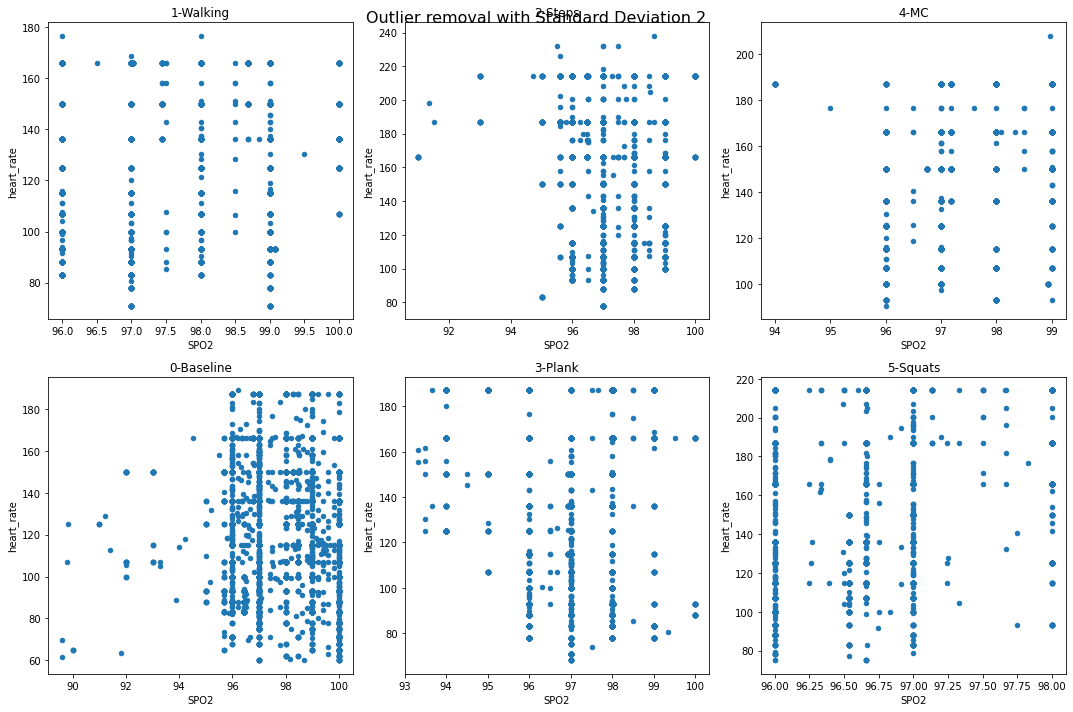

In [13]:
sub_plots(vitals_data_std, 'Outlier removal with Standard Deviation ' + str(sd), activities)

### DBSCAN 
Here we fit a model using able to identify clusters of each subset by looking at the local density of the data points, and afterwards, remove those that were considered as outliers.

Estimated number of clusters: 17
Estimated number of noise points: 56


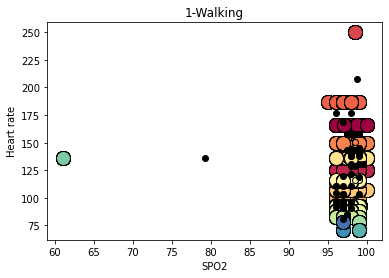

Estimated number of clusters: 33
Estimated number of noise points: 106


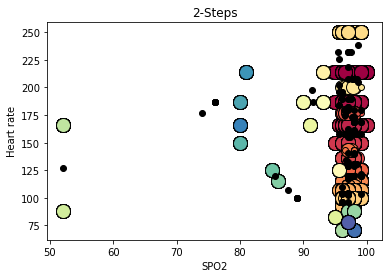

Estimated number of clusters: 23
Estimated number of noise points: 41


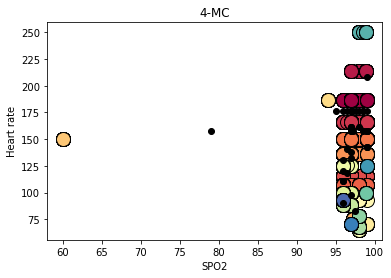

Estimated number of clusters: 49
Estimated number of noise points: 465


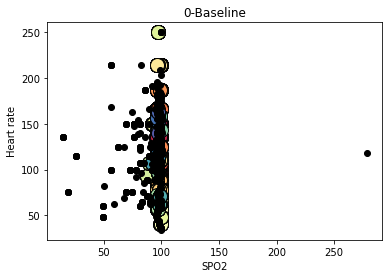

Estimated number of clusters: 26
Estimated number of noise points: 119


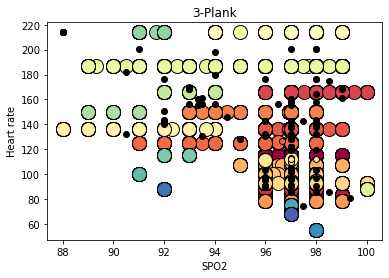

Estimated number of clusters: 16
Estimated number of noise points: 195


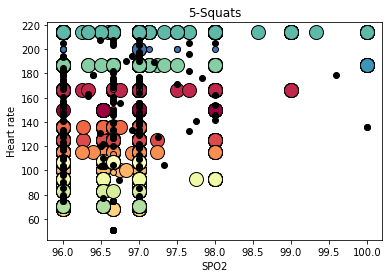

In [14]:
# Remove outliers with with DBSCAN
eps=1
min_samples=10

vitals_data_dbscan = []
for data, act in zip(vitals_data, activities):
    vitals_data_dbscan.append(outliers_cluster_dbscan(data,eps, min_samples,True, act))
 

After removing outlier with DBSCAN, we can see that there are some poits that still seems as outliers and are not removed, for instance, take a look at Walking exercie, one can note big clusters with SPO close 60, and heart rate around 250, those points are clearly outliers, but since the sensor records many repeated flawed data, the algorithm groups them together. That is why we decided not to use this algorithm for handling the outliers.

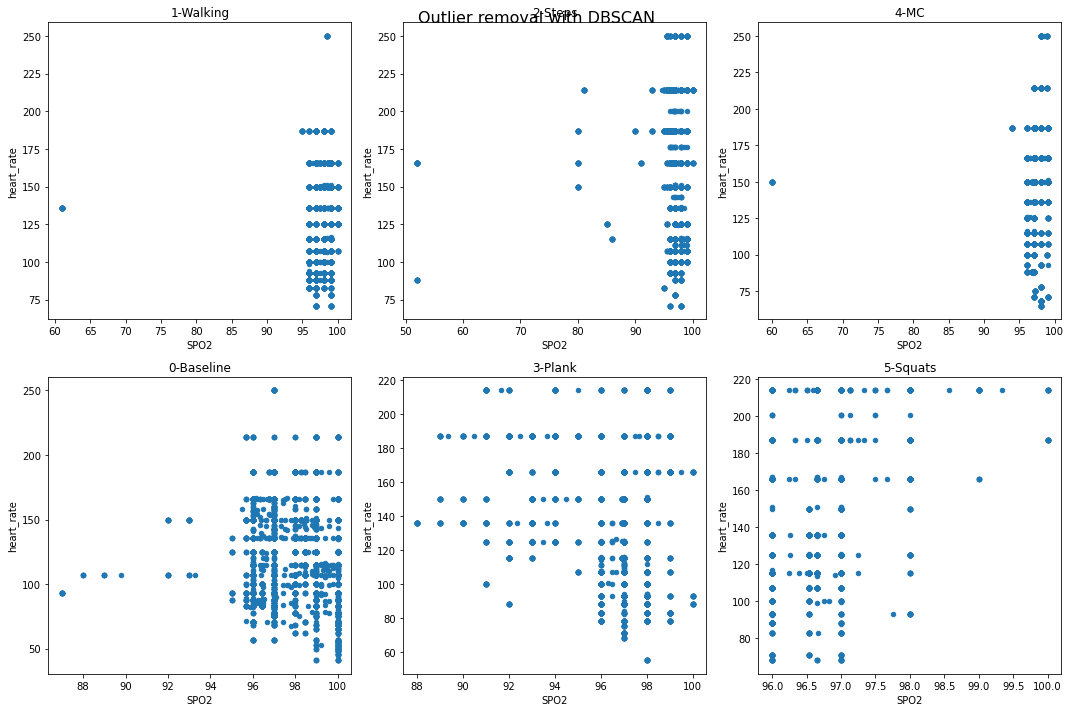

In [15]:
# Result for dbscan
sub_plots(vitals_data_dbscan, 'Outlier removal with DBSCAN', activities)

Afterwards we balance the sets (vitals and acc) of each exercise to be represented by the same amount of points and join everything together to have a single dataset with all the information.

In [16]:
#balance datasets of each exercise
m=3800

bal_set_v = [reduce_dataset_v(m, data) for data in vitals_data_std]
bal_set_a = [reduce_dataset_a(m, data) for data in acc_data]

In [17]:
# Join everything in a single dataset
df_v = bal_set_v[0].append(bal_set_v[1:]).reset_index(drop=True)
df_a = bal_set_a[0].append(bal_set_a[1:]).reset_index(drop=True)
data_set_group18 = pd.concat([df_v, df_a],axis=1)
data_set_group18

,person_id,exercise,spo_base,heart_rate_base,SPO,heart_rate,time,x,y,z,absolute
0,3,1,99.0,89.0,98.0,166.0,0.001116,-2.511477,3.085085,9.019045,NaN
1,3,1,99.0,89.0,98.0,166.0,0.191109,-3.381917,1.282982,8.426427,NaN
2,3,1,99.0,89.0,98.0,166.0,0.381102,-6.404432,-0.483046,4.493206,NaN
3,3,1,99.0,89.0,98.0,166.0,0.571095,-6.256539,-1.405577,4.783453,NaN
4,3,1,99.0,89.0,98.0,166.0,0.721090,-12.171190,-1.419798,4.847070,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22795,3,5,98.0,134.0,97.0,187.0,127.670459,-3.212219,1.753204,9.437866,NaN
22796,3,5,98.0,134.0,97.0,187.0,127.852832,-2.424530,2.837784,8.082748,NaN
22797,3,5,98.0,134.0,97.0,187.0,128.037707,-2.928513,3.874466,7.708054,NaN
22798,3,5,98.0,134.0,97.0,187.0,128.183093,-4.019073,4.524490,7.208862,NaN


In [18]:
data_set_group18.to_csv('sd2_avg_bal_data_set_group18_new_1.csv', sep=',')

The same approach was performed for building the test dataset.

In [19]:
# TEST set

data_type = ['vitals', 'acc']
test_vitals_acc_data = []

test_path= os.path.join(os.getcwd(),'test')

activities = [f.name for f in os.scandir(test_path) if f.is_dir()]

for act in activities:
    path = [os.path.join(test_path,act,f) for f in data_type]
    test_vitals_acc_data.append(get_datasets(path))
    

In [20]:
# Rows to take for each vital file
min=1000
# Rows to take for each acc file
n= 1000

test_red_data = []
test_concat_data = []

for act in test_vitals_acc_data:
    test_red_data.append(reduce_datset(min,n,act[0],act[1]))

for red in test_red_data:
    test_concat_data.append(concat_datsets(red[0], red[1]))
    
test_vitals_data = [x[0] for x in test_concat_data]
test_acc_data = [x[1] for x in test_concat_data]

In [21]:
# Remove outliers with Standard Deviation Method
sd = 2
test_vitals_data_std = [remove_outliers_sd(data,sd) for data in test_vitals_data]

In [22]:
# Re-sample acc files to match size of vital files
test_acc_data_bal = [reduce_dataset_a(len(v), a) for v,a in zip(test_vitals_data_std, test_acc_data)]

In [23]:
# Join everything in a single dataset

df_v = test_vitals_data_std[0].append(test_vitals_data_std[1:]).reset_index(drop=True)
df_a = test_acc_data_bal[0].append(test_acc_data_bal[1:]).reset_index(drop=True)
test_data_set_group18 = pd.concat([df_v, df_a],axis=1)
test_data_set_group18.to_csv('test_sd2avg_data_set_group18_1.csv', sep=',')
test_data_set_group18

,person_id,exercise,spo_base,heart_rate_base,SPO,heart_rate,time,x,y,z,absolute
0,4,1,99.0,70.0,97.0,115.0,0.022937,3.815865,6.317912,6.898704,10.102918
1,4,1,99.0,70.0,97.0,115.0,0.222932,1.819915,5.787265,7.450906,9.608357
2,4,1,99.0,70.0,97.0,115.0,0.322930,0.661624,5.443430,7.536528,9.320297
3,4,1,99.0,70.0,97.0,115.0,0.422928,-0.258363,5.411397,7.687414,9.404589
4,4,1,99.0,70.0,97.0,115.0,0.522925,0.476759,5.691465,8.060438,9.878802
...,...,...,...,...,...,...,...,...,...,...,...
10783,4,5,99.0,85.0,96.0,115.0,65.129131,-0.099094,5.482200,8.201595,9.865622
10784,4,5,99.0,85.0,96.0,115.0,65.189129,-0.666115,6.115383,8.219258,10.266344
10785,4,5,99.0,85.0,96.0,115.0,65.259128,-0.953966,5.878875,7.574549,9.635611
10786,4,5,99.0,85.0,96.0,115.0,65.319126,-0.970731,5.707032,8.189769,10.029200


## Data analytics

In [24]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

path = os.getcwd()
temp_df = pd.read_csv(os.path.join("sd2_avg_bal_data_set_group18_new_1.csv"),sep = ',')

Text(0.5, 0.98, 'SPO2 for all exercises')

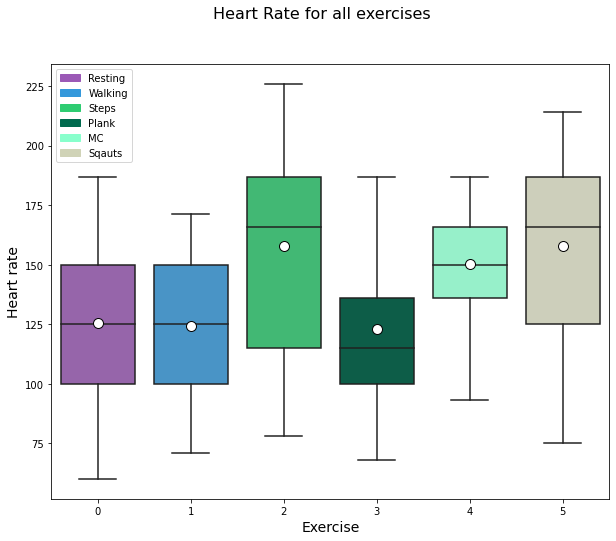

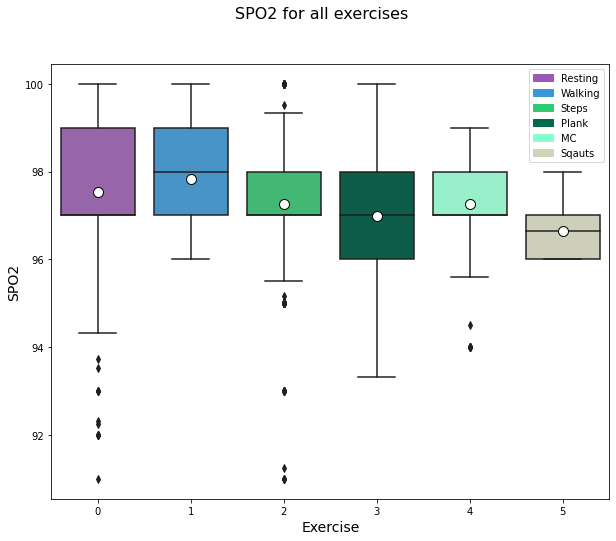

In [25]:
my_pal = ["#9b59b6", "#3498db", "#2ecc71", "#006a4e","#88ffcc", "#d0d3b7"]

plt.figure(figsize=(10, 8))
sns.boxplot(x="exercise",
            y="heart_rate", 
            data=temp_df, 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
           palette= my_pal )
plt.ylabel("Heart rate", size=14)
plt.xlabel("Exercise", size=14)


res = mpatches.Patch(color="#9b59b6", label='Resting')
walk = mpatches.Patch(color="#3498db", label='Walking')
step = mpatches.Patch(color="#2ecc71", label='Steps')
plank = mpatches.Patch(color="#006a4e", label='Plank')
mc = mpatches.Patch(color="#88ffcc", label='MC')
sq = mpatches.Patch(color="#d0d3b7", label='Sqauts')

plt.legend(handles=[res, walk, step, plank, mc, sq])
plt.suptitle('Heart Rate for all exercises', fontsize=16)


plt.figure(figsize=(10, 8))
sns.boxplot(x="exercise",
            y="SPO", 
            data=temp_df, 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
           palette = my_pal )
plt.ylabel("SPO2", size=14)
plt.xlabel("Exercise", size=14)
plt.legend(handles=[res, walk, step, plank, mc, sq])
plt.suptitle('SPO2 for all exercises', fontsize=16)

Text(0.5, 0.98, 'Heart rate per person in each activity')

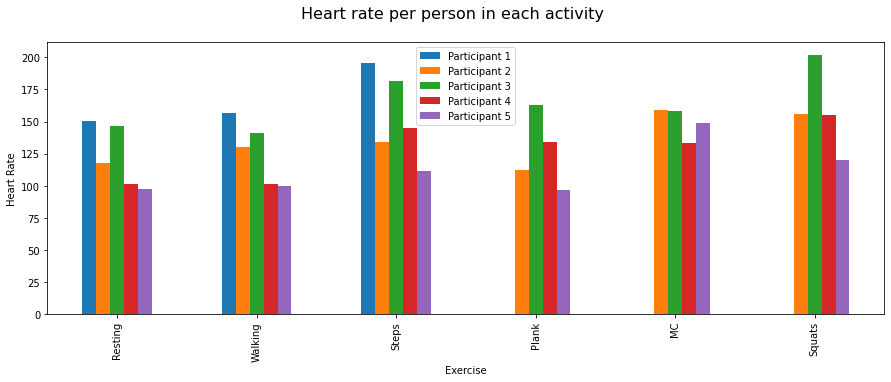

In [26]:
means = temp_df.groupby(['exercise', 'person_id'])["heart_rate"].mean()
means

plotdata = pd.DataFrame({
    "Participant 1":[means[0][1], means[1][1], means[2][1], 0,           0, 0],
    "Participant 2":[means[0][2], means[1][2], means[2][2], means[3][2], means[4][2], means[5][2]],
    "Participant 3":[means[0][3], means[1][3], means[2][3], means[3][3], means[4][3], means[5][3]],
    "Participant 4":[means[0][4], means[1][4], means[2][4], means[3][4], means[4][4], means[5][4]],
    "Participant 5":[means[0][5], means[1][5], means[2][5], means[3][5], means[4][5], means[5][5]],
               },
    index=["Resting", "Walking", "Steps", "Plank", "MC", "Squats"]
               ) 
plotdata.plot(kind="bar", figsize=(15,5))
plt.xlabel("Exercise")
plt.ylabel("Heart Rate")
plt.suptitle('Heart rate per person in each activity', fontsize=16)

Text(0.5, 0.98, 'Sensor vs Oximeter Instrument - Heart Rate')

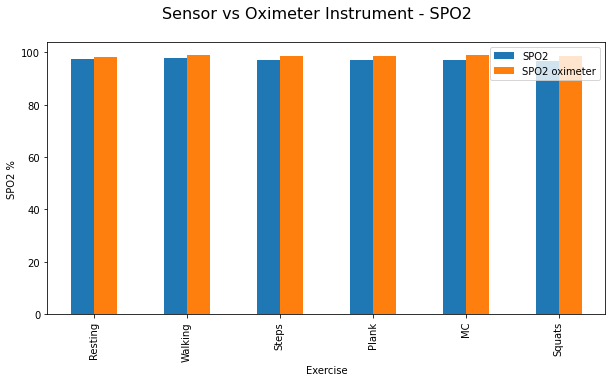

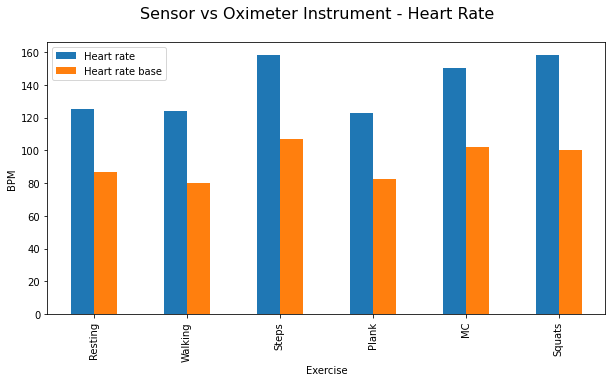

In [27]:
# Define the exercise labels and corresponding exercise codes
exercises = ["Resting", "Walking", "Steps", "Plank", "MC", "Squats"]

# Initialize dictionaries for SPO2 and Heart rate data
spo_dict = {"SPO2": [], "SPO2 oximeter": []}
hr_dict = {"Heart rate": [], "Heart rate base": []}

# Loop through the exercise codes and collect the means
for i, exercise in enumerate(exercises):
    # Filter by exercise type
    exercise_df = temp_df.loc[temp_df['exercise'] == i]
    
    # SPO2 data
    spo_dict["SPO2"].append(exercise_df.SPO.mean())
    spo_dict["SPO2 oximeter"].append(exercise_df.spo_base.mean())
    
    # Heart rate data
    hr_dict["Heart rate"].append(exercise_df.heart_rate.mean())
    hr_dict["Heart rate base"].append(exercise_df.heart_rate_base.mean())

# Create and plot the SPO2 data
plotdata = pd.DataFrame(spo_dict, index=exercises)
plotdata.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Exercise")
plt.ylabel("SPO2 %")
plt.suptitle('Sensor vs Oximeter Instrument - SPO2', fontsize=16)

# Create and plot the heart rate data
plotdata = pd.DataFrame(hr_dict, index=exercises)
plotdata.plot(kind="bar", figsize=(10, 5))
plt.xlabel("Exercise")
plt.ylabel("BPM")
plt.suptitle('Sensor vs Oximeter Instrument - Heart Rate', fontsize=16)